<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/Custom_Callback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLaB wit tensorflow version {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n>>>please load your drive...")
  COLAB = False
def time_fmt(t:float = 123.1829)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.3f}"
print(f"...testing time fmt...testing time fmt...\n>>>time elapse: {time_fmt()}")
  


Mounted at /content/drive
You are on CoLaB wit tensorflow version 2.4.1
...testing time fmt...testing time fmt...
>>>time elapse: 0: 02: 3.000


In [ ]:
#In this notebook we are going to excercise with tensorflow.keras.callback module
#We will build our custom keras model on cifar10 dataset by customize a callback 

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import Callback
import tensorflow_datasets as tfds
import os, datetime, sys, time 
%load_ext tensorboard

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJHI3ZH/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJHI3ZH/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

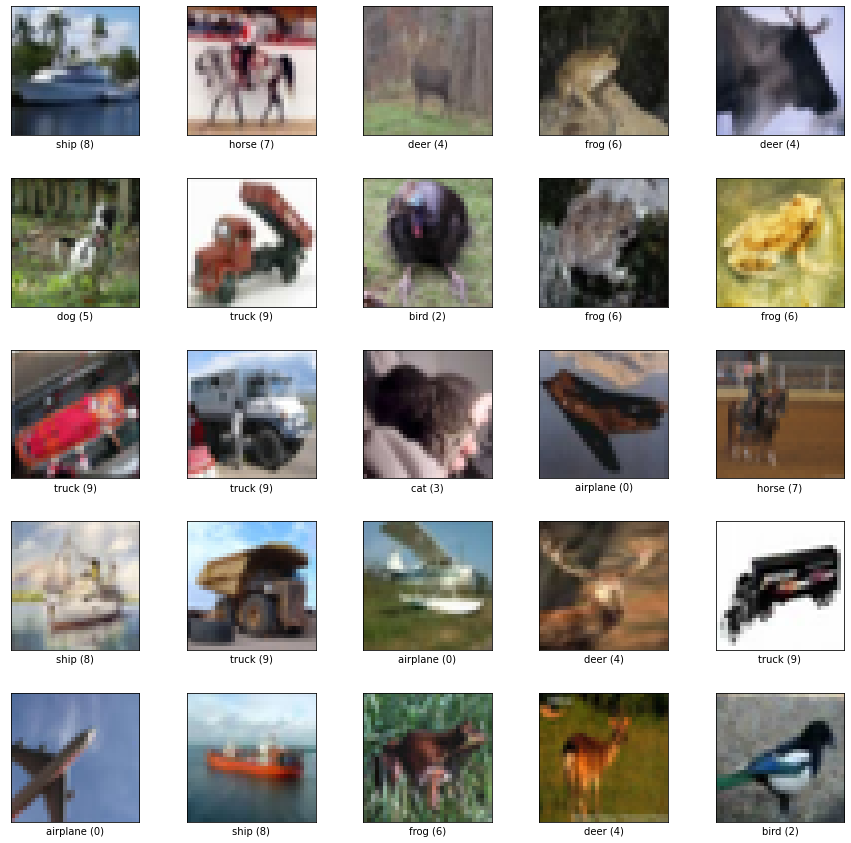

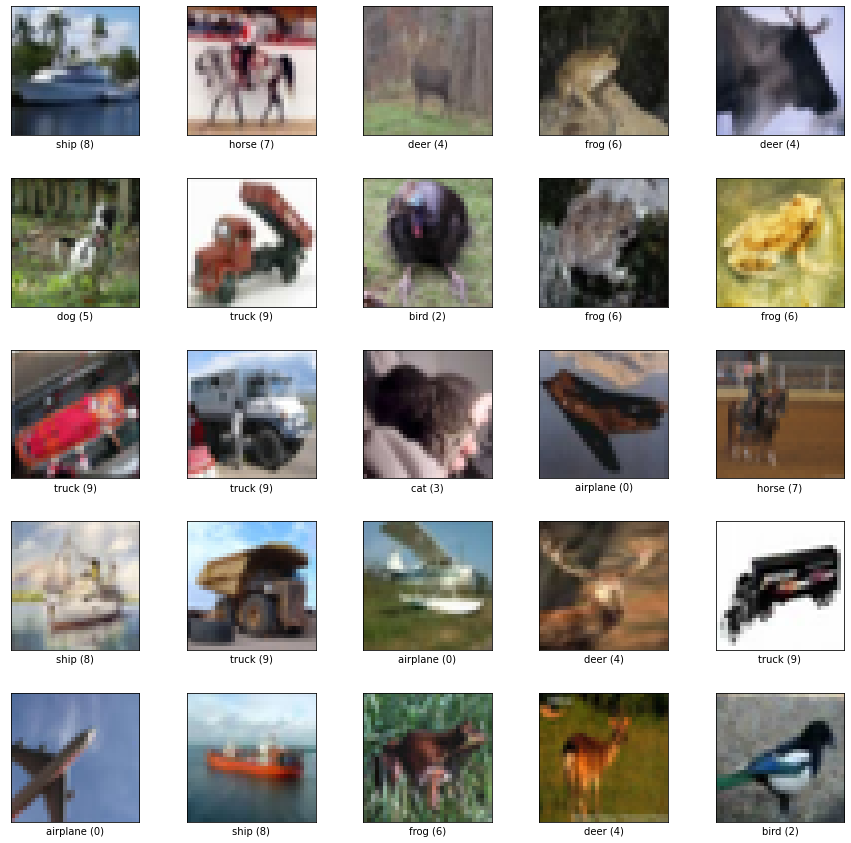

In [ ]:
#Loading and process the data:
(train_ds, test_ds), info_ds = tfds.load(
    name = 'cifar10', 
    shuffle_files = True,
    as_supervised = True,
    split = ['train', 'test'],
    with_info = True
)
display(info_ds)
#Display some few examples:
fig = tfds.show_examples(train_ds, info_ds, rows = 5, cols = 5)
display(fig)

In [ ]:
#Preprocess the data:
def img_preprocess(image, label):
  return tf.cast(image, tf.float32)/255.0, label

def data_aug(image, label):
  if tf.random.uniform((), minval = 0, maxval = 1)<=0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image), [1,1,3])
  image = tf.image.flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta = 0.2)
  image = tf.image.random_contrast(image, 0.2, 0.5)
  return image, label


In [ ]:
#Building the training and validation set:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
train_data = train_ds.map(img_preprocess, num_parallel_calls = AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(info_ds.splits['train'].num_examples)
train_data = train_data.map(data_aug)
train_data = train_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)
train_data = train_data.prefetch(AUTOTUNE)
test_data = test_ds.map(img_preprocess, num_parallel_calls = AUTOTUNE)
test_data = test_data.batch(batch_size = BATCH_SIZE, drop_remainder = True)


In [ ]:
#We now build a simple cnn network to train the above dataset:
class MyRelU(tf.keras.layers.Layer):
  def __init__(self, name = 'my_activation', *args, **kwargs):
    super(MyRelU, self).__init__(name = name, *args, **kwargs)
  def custom_relu(self, inputs_tensor):
    return tf.math.max(0, inputs_tensor)


In [ ]:
class CnnBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernels = 3, *args, **kwargs):
    super(CnnBlock, self).__init__(*args, **kwargs)
    self.conv = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = kernels,
                                       padding = 'same', strides = (1,1),
                                       kernel_initializer = 'random_normal')
    self.bn = tf.keras.layers.BatchNormalization()
    self.my_rElU = MyRelU()

  def call(self, inputs_tensor, training = False):
    x = self.conv(inputs_tensor, training = training)
    x = self.my_rElU(x)
    x = self.bn(x)
    return x

In [ ]:
class ResBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, *args, **kwargs):
    super(ResBlock, self).__init__(*args, **kwargs)
    self.block_1 = CnnBlock(num_filters = num_filters[0], name = 'block_1')
    self.block_2 = CnnBlock(num_filters = num_filters[1], name = 'block_2')
    self.block_3 = CnnBlock(num_filters = num_filters[2], name = 'block_3')
    self.max_pool = tf.keras.layers.MaxPooling2D()
    self.skip_connection = tf.keras.layers.Conv2D(filters = num_filters[1],kernel_size = 3, 
                                                  padding = 'same', activation = 'relu')
  def call(self, inputs_tensor, training = False):
    x = self.block_1(inputs_tensor, training = training)
    x = self.block_2(x, training = training)
    x = self.block_3(x + self.skip_connection(inputs_tensor), training = training)
    x = self.max_pool(x)
    return x


In [ ]:
class ResNet(tf.keras.Model):
  def __init__(self, labels = 10, *args, **kwargs):
    super(ResNet, self).__init__(*args, **kwargs)
    self.resblock_1 = ResBlock(num_filters = [32,64,128], name = 'resnlock_1')
    self.resblock_2 = ResBlock(num_filters = [64,128,256], name = 'resblock_2')
    self.resblock_3 = ResBlock(num_filters = [128,256,512], name = 'resblock_3')
    self.glb = tf.keras.layers.GlobalAveragePooling2D()
    self.dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_initializer = 'random_normal', name = 'dense1')
    self.drp = tf.keras.layers.Dropout(rate = 0.5, name = 'drop_out')
    self.dense2 = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'random_normal', name = 'dense2')
    self.outputs = tf.keras.layers.Dense(units = labels, name = 'outputs')
  def call(self, inputs_tensor, training = False):
    x = self.resblock_1(inputs_tensor, training = training)
    x = self.resblock_2(x, training = training)
    x = self.resblock_3(x, training = training)
    x = self.glb(x)
    x = self.dense1(x, training = training)
    x = self.drp(x)
    x = self.dense2(x, training = training)
    x = self.outputs(x, training = training)
    return x


In [ ]:
#Instantiating the model class:
model = ResNet()

In [ ]:
#Preparing the logs directory to write in tensorboard
log_dir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tfb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
#Custom Callback:
class CustomCallback(Callback):
  def on_train_begin(self, logs = None):
    print(f"begining of training\nplease wait....")
  def on_epoch_begin(self, epoch, logs = None):
    print(f"starting training for epoch: {epoch}")
  def on_train_batch_begin(self, batch, logs = None):
    print(f"training begin on batch: {batch}")
  def on_train_batch_end(self, batch, logs = None):
    print(f"training ending on batch: {batch}\nLoss is: {logs['loss']}")
  def on_epoch_end(self, epoch, logs = None):
    print(f"taining end on epoch: {epoch}\nLoss: {logs['loss']}, Accuracy: {logs['sparse_categorical_accuracy']}")
  def on_train_end(self, logs = None):
    print(f"training is done")

In [ ]:
#Now we can compile and train our model as follows:

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit(
    train_data, validation_data = test_data, epochs = 3,
    verbose = 2, callbacks = [tfb_callback, CustomCallback()]
)

begining of training
please wait....
Epoch 1/3
starting training for epoch: 0
training begin on batch: 0
training ending on batch: 0
Loss is: 1.2532873153686523
training begin on batch: 1
training ending on batch: 1
Loss is: 1.6513328552246094
training begin on batch: 2
training ending on batch: 2
Loss is: 1.6512359380722046
training begin on batch: 3
training ending on batch: 3
Loss is: 1.6864768266677856
training begin on batch: 4
training ending on batch: 4
Loss is: 1.618059515953064
training begin on batch: 5
training ending on batch: 5
Loss is: 1.599204659461975


training begin on batch: 6
training ending on batch: 6
Loss is: 1.5700929164886475
training begin on batch: 7
training ending on batch: 7
Loss is: 1.5371750593185425
training begin on batch: 8
training ending on batch: 8
Loss is: 1.5112723112106323
training begin on batch: 9
training ending on batch: 9
Loss is: 1.4837424755096436
training begin on batch: 10
training ending on batch: 10
Loss is: 1.459801435470581
training begin on batch: 11
training ending on batch: 11
Loss is: 1.4347363710403442
training begin on batch: 12
training ending on batch: 12
Loss is: 1.4277477264404297
training begin on batch: 13
training ending on batch: 13
Loss is: 1.406683087348938
training begin on batch: 14
training ending on batch: 14
Loss is: 1.3895937204360962
training begin on batch: 15
training ending on batch: 15
Loss is: 1.3748387098312378
training begin on batch: 16
training ending on batch: 16
Loss is: 1.3625357151031494
training begin on batch: 17
training ending on batch: 17
Loss is: 1.3538010

In [ ]:
%tensorboard --logdir logs